#### Adult Dataset

In [3]:
from ucimlrepo import fetch_ucirepo 
import json
import pandas as pd
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 

X = adult.data.features 
df_X = pd.DataFrame(X)
# 取10条数据
df_X = df_X[:1000]
df_X.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [4]:
# 制定映射规则，全都转为数值型
# 只取age, education-num, capital-gain, capital-loss, hours-per-week列
input_X = df_X.iloc[:, [0, 4, 10, 11, 12]]
# input_X转为ndarray
input_X = input_X.values
# input_X
y = adult.data.targets
df_y = y['income'].str.strip().str.rstrip('.')
# 制定df_y的映射规则
maps = {'<=50K': 0, 
       '>50K': 1}
input_y = df_y.map(maps).values
input_y = input_y[:1000]

input_X.shape, input_y.shape

((1000, 5), (1000,))

#### 构建邻接矩阵

Text(0.5, 1.0, 'Adult dataset Visualization')

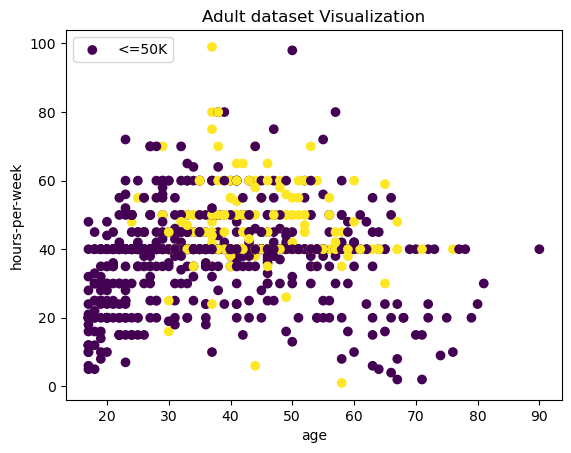

In [5]:
nodes = []
index = 0
from AdultNode import Node, Graph

for df, y in zip(input_X, input_y):
    node = Node(df, y, index)
    nodes.append(node)
    index += 1

%matplotlib inline
from matplotlib import pyplot as plt
# age, education-num, capital-gain, capital-loss, hours-per-week
plt.scatter(input_X[:, 0], input_X[:, 4], c=input_y)
# 图例
plt.legend(['<=50K', '>50K'], loc='upper left')
# 横轴名称：age， 纵轴名称：hours-per-week
plt.xlabel('age')
plt.ylabel('hours-per-week')
# 标题：Adult dataset: Initial Distribution
title = 'Adult dataset Visualization'
plt.title(title)

In [6]:
import numpy as np
DISTANCE = 5
graph = Graph(nodes, distance=DISTANCE)
adjacency_matrix = np.array(graph.get_adjacency_matrix())
print("邻接矩阵：", adjacency_matrix.shape)

#根据邻接矩阵获取所有的二元组，如：[(0, 1), (0, 2), (1, 2)]
edges = graph.get_edges()
print(f"Distance={DISTANCE}, 构建了{len(edges)}条边")

邻接矩阵： (1000, 1000)
Distance=5, 构建了17687条边


#### DeepWalk

In [7]:
import networkx as nx
from util import deepwalk

# Usage
nx = graph.to_nx()
embeddings = deepwalk(nx, walk_length=60, num_walks=200, dim=32)
print(type(embeddings))


<class 'dict'>


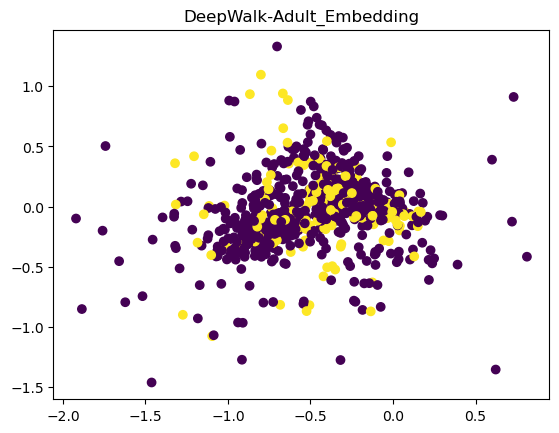

In [8]:
# 取两维做个可视化
# 随便取两个维度看看
x = [embedding[0] for embedding in list(embeddings.values()) if embedding is not None]
y = [embedding[1] for embedding in list(embeddings.values()) if embedding is not None]

label = [node.label for node in nodes if(embeddings[str(node.index)] is not None)]

# 创建散点图
plt.scatter(x, y, c=label)
plt.title("DeepWalk-Adult_Embedding")
# 显示图形
plt.show()

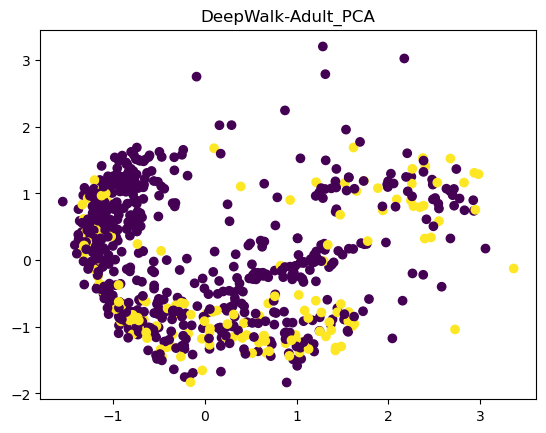

In [9]:
#PCA降维
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 先drop掉None
embeddings = {key: value for key, value in embeddings.items() if value is not None}
# 假设embeddings是一个字典，其中包含嵌入值
embeddings_value = list(embeddings.values())

# 使用PCA进行降维
pca = PCA(n_components=2)
pca.fit(embeddings_value)
X_pca = pca.transform(embeddings_value)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=label)
plt.title("DeepWalk-Adult_PCA")
plt.show()


### GIN

In [12]:
import os
import csv
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from scipy.sparse import csr_matrix
import networkx as nx

from scipy.linalg import orthogonal_procrustes

import torch
import torch.optim as optim
from torch_geometric.data import Data

from sklearn.manifold import TSNE

from util import Net, GIN, GAT, stationary, reconstruct, dG


np.random.seed(0)
torch.manual_seed(0)

x = np.array(input_X)# 1000*5
mu = np.mean(x, axis=0, keepdims=True)
std = np.std(x, axis=0, keepdims=True)
x = (x - mu) / std
n = len(x)
m = 500
# 分割训练集和测试集
n_train = int(n * 0.7)
train_ind = torch.randperm(n)[:n_train]
test_ind = torch.LongTensor(list(set(np.arange(n)) - set(train_ind.tolist())))
K = 300
# D = pairwise_distances(x) - 1e9 * np.eye(n)
D = pairwise_distances(x)# 邻接距离矩阵
# 二值化，得到邻接矩阵
A_binary = np.where(D <= DISTANCE, 1, 0)

# 获得所有的边，二元组格式
row_indices, col_indices = np.where(A_binary == 1)
edges = list(zip(row_indices, col_indices))

# 转为tensor
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(input_y, dtype=torch.long)
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()
data = Data(x=x, y=y, edge_index=edges)
print(data)


Data(x=[1000, 5], edge_index=[2, 900832], y=[1000])


In [14]:
net = GIN(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in range(10):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edges)
    rec = net(data)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])
    print(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_GIN = rec.detach().numpy() @ R.T
loss_GIN = float(dG(torch.FloatTensor(x), rec))

net = GAT(m)
optimizer = optim.Adam(net.parameters(), lr=0.001)
net.train()
for epoch in range(10):
    ind = torch.eye(n)[:, torch.randperm(n)[:m]]
    X_extended = torch.hstack([X, ind])
    data = Data(x=X_extended, edge_index=edges)
    rec = net(data)
    loss = dG(torch.FloatTensor(x)[train_ind], rec[train_ind])
    print(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

R, _ = orthogonal_procrustes(x, rec.detach().numpy())
rec_GAT = rec.detach().numpy() @ R.T
loss_GAT = float(dG(torch.FloatTensor(x), rec))

ind = torch.eye(n)[:, torch.randperm(n)[:m]]
X_extended = torch.hstack([X, ind])
X_embedded = TSNE(n_components=2, random_state=0, init='pca').fit_transform(X_extended.numpy())
loss_tSNE = float(dG(torch.FloatTensor(x), X_embedded))


c = x[:, 0].argsort().argsort()
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(x[:, 0], x[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('#eeeeee')
txt = ax.text(0.05, 0.05, 'Ground Truth', color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='#eeeeee')])

# visible = plt.imread('./imgs/visible.png')
# visible_ax = fig.add_axes([0.24, 0.77, 0.1, 0.1], anchor='NE', zorder=1)
# visible_ax.imshow(visible)
# visible_ax.axis('off')

G = nx.DiGraph()
ax = fig.add_subplot(1, 3, 2)
ax.scatter(rec_GIN[:, 0], rec_GIN[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GIN $d_G = {:.2f}$'.format(loss_GIN), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

ax = fig.add_subplot(1, 3, 3)
ax.scatter(rec_GAT[:, 0], rec_GAT[:, 1], c=c, s=10, rasterized=True)
ax.set_xticks([])
ax.set_yticks([])
txt = ax.text(0.05, 0.05, 'GAT $d_G = {:.2f}$'.format(loss_GAT), color='k', fontsize=14, weight='bold', transform=ax.transAxes)
txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

fig.subplots_adjust()

if not os.path.exists('imgs'):
    os.mkdir('imgs')

fig.savefig('imgs/semi_adult.png', bbox_inches='tight', dpi=300)

TypeError: expected Tensor as element 0 in argument 0, but got DataFrame